# ufunc_call_i4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

M, N = 100, 100

x1 = allocate(shape=(M, N), dtype="i4")
x2 = allocate(shape=(M, N), dtype="i4")
out = allocate(shape=(M, N), dtype="i4")

x1[:] = np.random.rand(*x1.shape) + 1
x2[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def add_call_i4_numpy(x1, x2, out):
    out[:] = x1 + x2

def subtract_call_i4_numpy(x1, x2, out):
    out[:] = x1 - x2

def multiply_call_i4_numpy(x1, x2, out):
    out[:] = x1 * x2

def true_divide_call_i4_numpy(x1, x2, out):
    out[:] = x1 / x2

def sqrt_call_i4_numpy(x1, out):
    out[:] = np.sqrt(x1)

def exp_call_i4_numpy(x1, out):
    out[:] = np.exp(x1)

def log_call_i4_numpy(x1, out):
    out[:] = np.log(x1)

out[:] = 0
add_call_i4_numpy(x1, x2, out)
print(f"add_call_i4_numpy = {out}")

out[:] = 0
subtract_call_i4_numpy(x1, x2, out)
print(f"subtract_call_i4_numpy = {out}")

out[:] = 0
multiply_call_i4_numpy(x1, x2, out)
print(f"multiply_call_i4_numpy = {out}")

out[:] = 0
true_divide_call_i4_numpy(x1, x2, out)
print(f"true_divide_call_i4_numpy = {out}")

out[:] = 0
sqrt_call_i4_numpy(x1, out)
print(f"sqrt_call_i4_numpy = {out}")

out[:] = 0
exp_call_i4_numpy(x1, out)
print(f"exp_call_i4_numpy = {out}")

out[:] = 0
log_call_i4_numpy(x1, out)
print(f"log_call_i4_numpy = {out}")

add_call_i4_numpy = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
subtract_call_i4_numpy = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
multiply_call_i4_numpy = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
true_divide_call_i4_numpy = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
sqrt_call_i4_numpy = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
exp_call_i4_numpy = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
log_call_i4_numpy = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
NONE = 0
ADD = 1
MULTIPLY = 2
SQUARE = 3
EXP = 4
LOG = 5
ABSDIFF = 6
SUBTRACT = 7
TRUE_DIVIDE = 8
SIN = 9
SQRT = 10
ARCTAN = 11
SINH = 12

def add_call_i4_pynq(x1, x2, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, ADD)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def subtract_call_i4_pynq(x1, x2, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, SUBTRACT)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def multiply_call_i4_pynq(x1, x2, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, MULTIPLY)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def true_divide_call_i4_pynq(x1, x2, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, TRUE_DIVIDE)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def sqrt_call_i4_pynq(x1, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, SQRT)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def exp_call_i4_pynq(x1, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, EXP)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def log_call_i4_pynq(x1, out):
    overlay.ufunc_call_i4_0.mmio.write(0x10, LOG)  # Set the args
    overlay.ufunc_call_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

out[:] = 0
add_call_i4_pynq(x1, x2, out)
print(f"add_call_i4_pynq = {out}")

out[:] = 0
subtract_call_i4_pynq(x1, x2, out)
print(f"subtract_call_i4_pynq = {out}")

out[:] = 0
multiply_call_i4_pynq(x1, x2, out)
print(f"multiply_call_i4_pynq = {out}")

out[:] = 0
true_divide_call_i4_pynq(x1, x2, out)
print(f"true_divide_call_i4_pynq = {out}")

out[:] = 0
sqrt_call_i4_pynq(x1, out)
print(f"sqrt_call_i4_pynq = {out}")

out[:] = 0
exp_call_i4_pynq(x1, out)
print(f"exp_call_i4_pynq = {out}")

out[:] = 0
log_call_i4_pynq(x1, out)
print(f"log_call_i4_pynq = {out}")

add_call_i4_pynq = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
subtract_call_i4_pynq = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
multiply_call_i4_pynq = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
true_divide_call_i4_pynq = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
sqrt_call_i4_pynq = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
exp_call_i4_pynq = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
log_call_i4_pynq = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 ufunc_call_i4_pybind11

#include "defines.h"

#define NONE 0
#define ADD 1
#define MULTIPLY 2
#define SQUARE 3
#define EXP 4
#define LOG 5
#define ABSDIFF 6
#define SUBTRACT 7
#define TRUE_DIVIDE 8
#define SIN 9
#define SQRT 10
#define ARCTAN 11
#define SINH 12

void add_call_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(ADD);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void subtract_call_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(SUBTRACT);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void multiply_call_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(MULTIPLY);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void true_divide_call_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(TRUE_DIVIDE);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void sqrt_call_i4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(SQRT);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void exp_call_i4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(EXP);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void log_call_i4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_i4_0_args_args_w(LOG);
    ufunc_call_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"ufunc_call_i4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import ufunc_call_i4_pybind11 as calc

def add_call_i4_pybind11(x1, x2, out):
    calc.add_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def subtract_call_i4_pybind11(x1, x2, out):
    calc.subtract_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def multiply_call_i4_pybind11(x1, x2, out):
    calc.multiply_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def true_divide_call_i4_pybind11(x1, x2, out):
    calc.true_divide_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def sqrt_call_i4_pybind11(x1, out):
    calc.sqrt_call_i4(x1.physical_address, out.physical_address, x1.nbytes)

def exp_call_i4_pybind11(x1, out):
    calc.exp_call_i4(x1.physical_address, out.physical_address, x1.nbytes)

def log_call_i4_pybind11(x1, out):
    calc.log_call_i4(x1.physical_address, out.physical_address, x1.nbytes)


out[:] = 0
add_call_i4_pybind11(x1, x2, out)
print(f"add_call_i4_pybind11 = {out}")

out[:] = 0
subtract_call_i4_pybind11(x1, x2, out)
print(f"subtract_call_i4_pybind11 = {out}")

out[:] = 0
multiply_call_i4_pybind11(x1, x2, out)
print(f"multiply_call_i4_pybind11 = {out}")

out[:] = 0
true_divide_call_i4_pybind11(x1, x2, out)
print(f"true_divide_call_i4_pybind11 = {out}")

out[:] = 0
sqrt_call_i4_pybind11(x1, out)
print(f"sqrt_call_i4_pybind11 = {out}")

out[:] = 0
exp_call_i4_pybind11(x1, out)
print(f"exp_call_i4_pybind11 = {out}")

out[:] = 0
log_call_i4_pybind11(x1, out)
print(f"log_call_i4_pybind11 = {out}")

add_call_i4_pybind11 = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
subtract_call_i4_pybind11 = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
multiply_call_i4_pybind11 = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
true_divide_call_i4_pybind11 = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
sqrt_call_i4_pybind11 = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
exp_call_i4_pybind11 = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
log_call_i4_pybind11 = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]


# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_ufunc_call_i4_cffi.py

from cffi import FFI
ffibuilder = FFI()

# Add all C definitions below...

ffibuilder.cdef(
    r"""
void add_call_i4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void subtract_call_i4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void multiply_call_i4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void true_divide_call_i4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void sqrt_call_i4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void exp_call_i4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void log_call_i4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
    """
)

with open("ufunc_call_i4.c") as f:
    ffibuilder.set_source("ufunc_call_i4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_ufunc_call_i4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_ufunc_call_i4_cffi.py
cp ufunc_call_i4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp ufunc_call_i4_pybind11.so ../

generating ./ufunc_call_i4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/ufunc_call_i4'
running build_ext
building 'ufunc_call_i4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c ufunc_call_i4_cffi.c -o ./ufunc_call_i4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./ufunc_call_i4_cffi.o -o ./ufunc_call_i4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from ufunc_call_i4_cffi.c:569:0:
defines.h:171:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from ufunc_call_i4_cffi import lib as calc

def add_call_i4_cffi(x1, x2, out):
    calc.add_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def subtract_call_i4_cffi(x1, x2, out):
    calc.subtract_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def multiply_call_i4_cffi(x1, x2, out):
    calc.multiply_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def true_divide_call_i4_cffi(x1, x2, out):
    calc.true_divide_call_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def sqrt_call_i4_cffi(x1, out):
    calc.sqrt_call_i4(x1.physical_address, out.physical_address, x1.nbytes)

def exp_call_i4_cffi(x1, out):
    calc.exp_call_i4(x1.physical_address, out.physical_address, x1.nbytes)

def log_call_i4_cffi(x1, out):
    calc.log_call_i4(x1.physical_address, out.physical_address, x1.nbytes)


out[:] = 0
add_call_i4_cffi(x1, x2, out)
print(f"add_call_i4_cffi = {out}")

out[:] = 0
subtract_call_i4_cffi(x1, x2, out)
print(f"subtract_call_i4_cffi = {out}")

out[:] = 0
multiply_call_i4_cffi(x1, x2, out)
print(f"multiply_call_i4_cffi = {out}")

out[:] = 0
true_divide_call_i4_cffi(x1, x2, out)
print(f"true_divide_call_i4_cffi = {out}")

out[:] = 0
sqrt_call_i4_cffi(x1, out)
print(f"sqrt_call_i4_cffi = {out}")

out[:] = 0
exp_call_i4_cffi(x1, out)
print(f"exp_call_i4_cffi = {out}")

out[:] = 0
log_call_i4_cffi(x1, out)
print(f"log_call_i4_cffi = {out}")

add_call_i4_cffi = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
subtract_call_i4_cffi = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
multiply_call_i4_cffi = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
true_divide_call_i4_cffi = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
sqrt_call_i4_cffi = [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
exp_call_i4_cffi = [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
log_call_i4_cffi = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## add_call_i4


kernel = numpy, n = 16, t = 0.0003468233
kernel = pynq, n = 16, t = 0.1396823231
kernel = pybind11, n = 16, t = 0.0004146735
kernel = cffi, n = 16, t = 0.00014607010000000002
kernel = numpy, n = 32, t = 0.0003676907
kernel = pynq, n = 32, t = 0.1391141007
kernel = pybind11, n = 32, t = 0.0001596465
kernel = cffi, n = 32, t = 0.00021527020000000003
kernel = numpy, n = 64, t = 0.0003699311
kernel = pynq, n = 64, t = 0.1392125603
kernel = pybind11, n = 64, t = 0.0001623833
kernel = cffi, n = 64, t = 0.0002173953
kernel = numpy, n = 128, t = 0.0003862142
kernel = pynq, n = 128, t = 0.1389326316
kernel = pybind11, n = 128, t = 0.0001659409
kernel = cffi, n = 128, t = 0.00021534070000000003
kernel = numpy, n = 256, t = 0.0004303231
kernel = pynq, n = 256, t = 0.1390725826
kernel = pybind11, n = 256, t = 0.00039624740000000004
kernel = cffi, n = 256, t = 0.0001434459
kernel = numpy, n = 512, t = 0.0004739871
kernel = pynq, n = 512, t = 0.1392000327
kernel = pybind11, n = 512, t = 0.0003997923

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.167645625e-05    │ 0.00873014519375  │ 2.591709375e-05    │ 9.12938125000000… │
│ 32      │ 1.1490334375e-05   │ 0.004347315646875 │ 4.988953125e-06    │ 6.72719375000000… │
│ 64      │ 5.7801734375e-06   │ 0.00217519625468… │ 2.5372390625e-06   │ 3.3968015625e-06  │
│ 128     │ 3.0172984375e-06   │ 0.001085411184375 │ 1.29641328125e-06  │ 1.68234921875000… │
│ 256     │ 1.680949609375e-06 │ 0.00054325227578… │ 1.547841406250000… │ 5.60335546875e-07 │
│ 512     │ 9.257560546875e-07 │ 0.00027187506386… │ 7.808443359375e-07 │ 3.20907421875e-07 │
│ 1024    │ 6.1791259765625e-… │ 0.00013621553046… │ 1.740835937500000… │ 2.87767773437500… │
│ 2048    │ 4.51874560546875e… │ 6.805071640625e-… │ 9.552841796875002… │ 1.12333837890625… │
│ 4096    │ 4.1060087890625e-… │ 3.40399876953125… │ 1.06528466796875e… │ 6.2390478515625e… │
│ 8192    │ 3.661018798828125… │ 1.70514807250976… │ 3.118970947265625… │ 4.47865356445312… │
│ 16384   │ 3.478203674316407… │ 8.52394124145508… │ 3.589649658203125… │ 2.66750244140625… │
│ 32768   │ 3.357252075195312… │ 4.26723459167480… │ 2.168820495605468… │ 1.83509063720703… │
│ 65536   │ 3.352500701904297… │ 2.13202961883544… │ 1.572102813720703… │ 1.36402542114257… │
│ 131072  │ 3.442366844177247… │ 1.06711693954467… │ 1.129897384643554… │ 1.13253921508789… │
│ 262144  │ 3.423416202545166… │ 5.34272861862182… │ 1.063254241943359… │ 1.06023948669433… │
│ 524288  │ 3.406606510162353… │ 2.6774443359375e… │ 1.030769100189209… │ 1.02847747802734… │
│ 1048576 │ 3.403827949523926… │ 1.35077126121521… │ 1.016622390747070… │ 1.08951458930969… │
│ 2097152 │ 3.404255042076111… │ 6.82715701103210… │ 1.008256587982177… │ 1.00811162948608… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

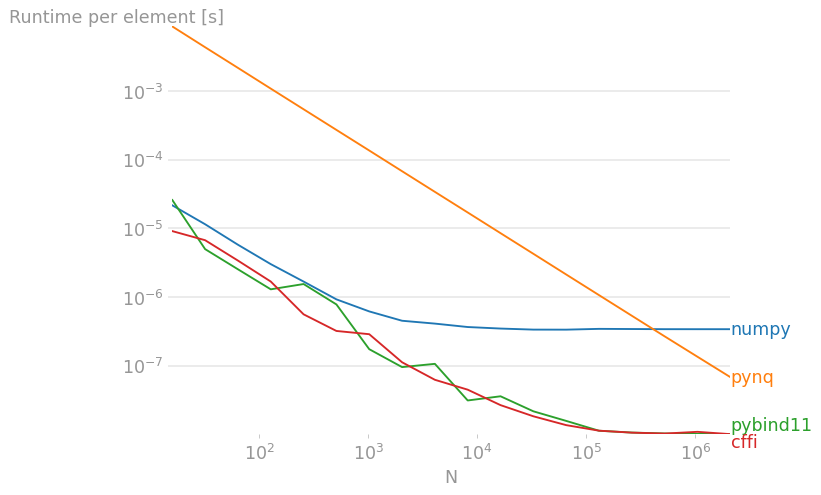

pynq_min = 262144
pybind11_min = 16
cffi_min = 0
Bitstream download time = 0.21618936600000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.167645625e-05    │ 0.02224198056875  │ 0.01353775246875   │ 0.01352096475625… │
│ 32      │ 1.1490334375e-05   │ 0.011103233334375 │ 0.006760906640625… │ 0.00676264488125… │
│ 64      │ 5.7801734375e-06   │ 0.00555315509843… │ 0.003380496082812… │ 0.00338135564531… │
│ 128     │ 3.0172984375e-06   │ 0.00277439060625  │ 0.001690275835156… │ 0.00169066177109… │
│ 256     │ 1.680949609375e-06 │ 0.00138774198671… │ 0.000846037552343… │ 0.00084505004648… │
│ 512     │ 9.257560546875e-07 │ 0.00069411991933… │ 0.000423025699804… │ 0.00042256576289… │
│ 1024    │ 6.1791259765625e-… │ 0.00034733795820… │ 0.000211296511328… │ 0.00021141019550… │
│ 2048    │ 4.51874560546875e… │ 0.00017361193027… │ 0.000105656742285… │ 0.00010567354770… │
│ 4096    │ 4.1060087890625e-… │ 8.68205946289062… │ 5.288713540039063… │ 5.28429974121093… │
│ 8192    │ 3.661018798828125… │ 4.34417841918945… │ 2.642149317626953… │ 2.64350900024414… │
│ 16384   │ 3.478203674316407… │ 2.17190929748535… │ 1.323104822998047… │ 1.32218267578125… │
│ 32768   │ 3.357252075195312… │ 1.08648104583740… │ 6.619264071655274… │ 6.61592677307129… │
│ 65536   │ 3.352500701904297… │ 5.43081755218505… │ 3.314508961486817… │ 3.31242818756103… │
│ 131072  │ 3.442366844177247… │ 2.71651090621948… │ 1.660692940521240… │ 1.66071935882568… │
│ 262144  │ 3.423416202545166… │ 1.35896984519958… │ 8.35329525756836e… │ 8.35299378204345… │
│ 524288  │ 3.406606510162353… │ 6.80092925262451… │ 4.226561826705933… │ 4.22633266448974… │
│ 1048576 │ 3.403827949523926… │ 3.41251371955871… │ 2.163404697418213… │ 2.17069391727447… │
│ 2097152 │ 3.404255042076111… │ 1.71358693027496… │ 1.131696887969970… │ 1.13168239212036… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

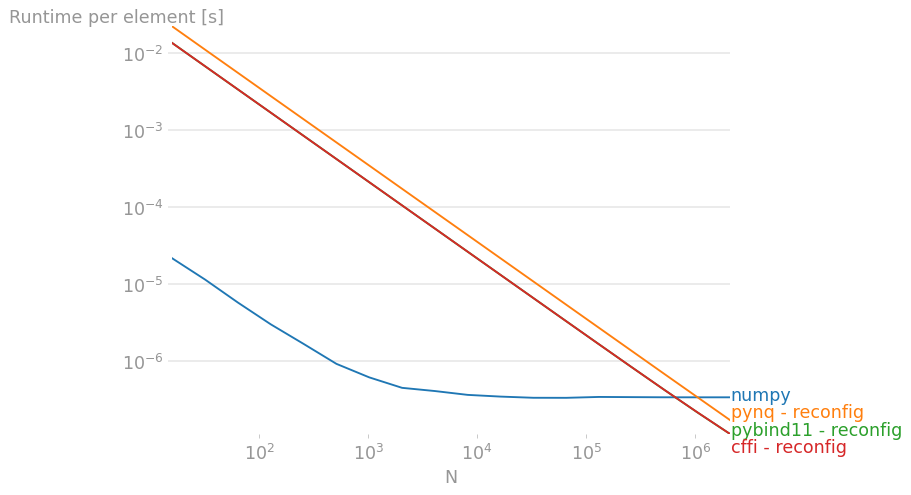

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    x2 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [add_call_i4_numpy, add_call_i4_pynq, add_call_i4_pybind11, add_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## subtract_call_i4


kernel = numpy, n = 16, t = 0.0004118705
kernel = pynq, n = 16, t = 0.1407208628
kernel = pybind11, n = 16, t = 0.0004138338
kernel = cffi, n = 16, t = 0.0001492658
kernel = numpy, n = 32, t = 0.0003601305
kernel = pynq, n = 32, t = 0.13954367830000003
kernel = pybind11, n = 32, t = 0.0004122816
kernel = cffi, n = 32, t = 0.00015016560000000002
kernel = numpy, n = 64, t = 0.0003785311
kernel = pynq, n = 64, t = 0.13979474230000002
kernel = pybind11, n = 64, t = 0.00041177670000000006
kernel = cffi, n = 64, t = 0.000150413
kernel = numpy, n = 128, t = 0.0003844645
kernel = pynq, n = 128, t = 0.1398100886
kernel = pybind11, n = 128, t = 0.0004274821
kernel = cffi, n = 128, t = 0.0001522944
kernel = numpy, n = 256, t = 0.00042929690000000005
kernel = pynq, n = 256, t = 0.1400048419
kernel = pybind11, n = 256, t = 0.0001642218
kernel = cffi, n = 256, t = 0.0002165725
kernel = numpy, n = 512, t = 0.0004749182
kernel = pynq, n = 512, t = 0.13976112380000003
kernel = pybind11, n = 512, t = 0.

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.574190625e-05    │ 0.008795053925    │ 2.58646125e-05     │ 9.3291125e-06     │
│ 32      │ 1.1254078125e-05   │ 0.00436073994687… │ 1.28838e-05        │ 4.69267500000000… │
│ 64      │ 5.9145484375e-06   │ 0.00218429284843… │ 6.434010937500001… │ 2.350203125e-06   │
│ 128     │ 3.00362890625e-06  │ 0.00109226631718… │ 3.33970390625e-06  │ 1.1898e-06        │
│ 256     │ 1.676941015625000… │ 0.00054689391367… │ 6.4149140625e-07   │ 8.45986328125e-07 │
│ 512     │ 9.27574609375e-07  │ 0.00027297094492… │ 8.249591796875e-07 │ 3.081345703125e-… │
│ 1024    │ 6.355008789062501… │ 0.00013678460742… │ 4.125475585937500… │ 1.5323193359375e… │
│ 2048    │ 4.40941259765625e… │ 6.84513402832031… │ 2.152160156250000… │ 1.17460595703125… │
│ 4096    │ 4.177681640625e-07 │ 3.40919539550781… │ 5.31297119140625e… │ 7.93145751953125… │
│ 8192    │ 3.66527685546875e… │ 1.72035812377929… │ 3.054703369140625… │ 4.51791748046875… │
│ 16384   │ 3.473762939453125… │ 8.56094381713867… │ 2.063623046875000… │ 2.66605102539062… │
│ 32768   │ 3.354973907470703… │ 4.28421964721679… │ 1.558210754394531… │ 1.6925830078125e… │
│ 65536   │ 3.354293594360352… │ 2.14061923217773… │ 1.269636993408203… │ 1.35957366943359… │
│ 131072  │ 3.328317199707032… │ 1.07187657623291… │ 1.127926177978515… │ 1.13510528564453… │
│ 262144  │ 3.425417575836182… │ 5.35901084518432… │ 1.071166038513183… │ 1.05897449493408… │
│ 524288  │ 3.403665256500244… │ 2.68609803771972… │ 1.034840106964111… │ 1.03098949432373… │
│ 1048576 │ 3.413292388916016… │ 1.35755268192291… │ 1.016051206588745… │ 1.01666076660156… │
│ 2097152 │ 3.392198761463166… │ 6.86361646652221… │ 1.008260755538940… │ 1.00814675331115… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

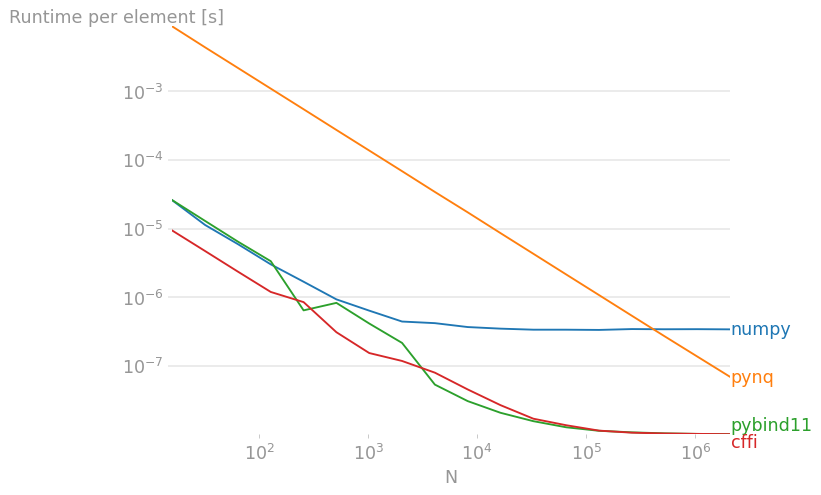

pynq_min = 262144
pybind11_min = 128
cffi_min = 0
Bitstream download time = 0.21486986500000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.574190625e-05    │ 0.0222244204875   │ 0.013455231175000… │ 0.013438695675    │
│ 32      │ 1.1254078125e-05   │ 0.01107542322812… │ 0.006727567081250… │ 0.00671937595625… │
│ 64      │ 5.9145484375e-06   │ 0.00554163448906… │ 0.003363775651562… │ 0.00335969184375  │
│ 128     │ 3.00362890625e-06  │ 0.00277093713750… │ 0.001682010524218… │ 0.00167986062031… │
│ 256     │ 1.676941015625000… │ 0.00138622932382… │ 0.000839976901562… │ 0.00084018139648… │
│ 512     │ 9.27574609375e-07  │ 0.00069263865000… │ 0.000420492664257… │ 0.00041997583964… │
│ 1024    │ 6.355008789062501… │ 0.00034661845996… │ 0.000210246400097… │ 0.00020998708447… │
│ 2048    │ 4.40941259765625e… │ 0.00017336826655… │ 0.000105132142285… │ 0.00010503438686… │
│ 4096    │ 4.177681640625e-07 │ 8.65504170898437… │ 5.251159284667969… │ 5.25377777099609… │
│ 8192    │ 3.66527685546875e… │ 4.34328128051757… │ 2.625977860107422… │ 2.62744107421875… │
│ 16384   │ 3.473762939453125… │ 2.16755596008300… │ 1.313525201416015… │ 1.31412762939453… │
│ 32768   │ 3.354973907470703… │ 1.08415275390625… │ 6.572889999389649… │ 6.57423372192382… │
│ 65536   │ 3.354293594360352… │ 5.41927317810058… │ 3.291350315856933… │ 3.29224968261718… │
│ 131072  │ 3.328317199707032… │ 2.71120354919433… │ 1.650606234741211… │ 1.65067802581787… │
│ 262144  │ 3.425417575836182… │ 1.35556457099914… │ 8.303751468658448… │ 8.30253231430053… │
│ 524288  │ 3.403665256500244… │ 6.78441547012329… │ 4.201801443099976… │ 4.20141638183593… │
│ 1048576 │ 3.413292388916016… │ 3.40671139812469… │ 2.150763836860657… │ 2.15082479286193… │
│ 2097152 │ 3.392198761463166… │ 1.71094100475311… │ 1.125405433654785… │ 1.12539403343200… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

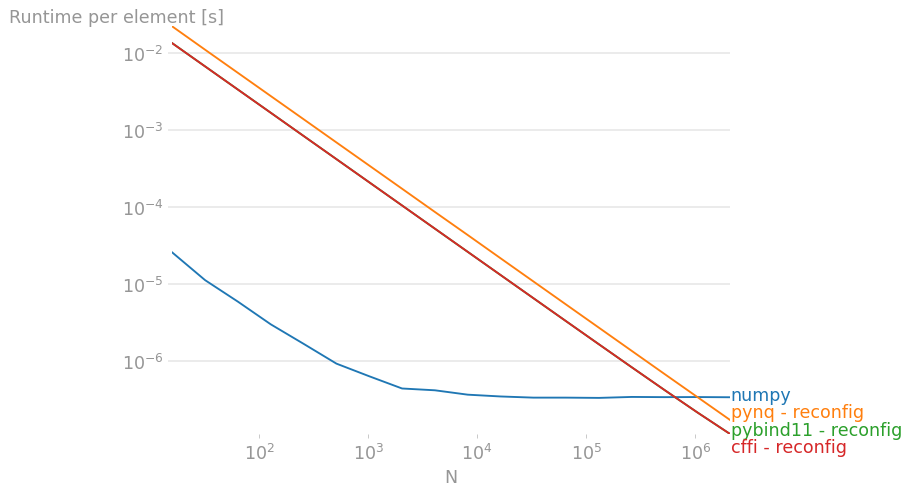

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [11]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    x2 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [subtract_call_i4_numpy, subtract_call_i4_pynq, subtract_call_i4_pybind11, subtract_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## multiply_call_i4


kernel = numpy, n = 16, t = 0.0003434716
kernel = pynq, n = 16, t = 0.14044187630000002
kernel = pybind11, n = 16, t = 0.0001689465
kernel = cffi, n = 16, t = 0.000212188
kernel = numpy, n = 32, t = 0.00035887690000000003
kernel = pynq, n = 32, t = 0.1408237072
kernel = pybind11, n = 32, t = 0.00016807410000000002
kernel = cffi, n = 32, t = 0.0002143028
kernel = numpy, n = 64, t = 0.00036932070000000004
kernel = pynq, n = 64, t = 0.13980929830000002
kernel = pybind11, n = 64, t = 0.0004155183
kernel = cffi, n = 64, t = 0.00014298010000000002
kernel = numpy, n = 128, t = 0.0003789591
kernel = pynq, n = 128, t = 0.1399583435
kernel = pybind11, n = 128, t = 0.0001644785
kernel = cffi, n = 128, t = 0.00021465570000000003
kernel = numpy, n = 256, t = 0.00042937140000000003
kernel = pynq, n = 256, t = 0.1397478665
kernel = pybind11, n = 256, t = 0.0001729637
kernel = cffi, n = 256, t = 0.00021835200000000003
kernel = numpy, n = 512, t = 0.0004944886000000001
kernel = pynq, n = 512, t = 0.139

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.1466975e-05      │ 0.00877761726875… │ 1.055915625e-05    │ 1.326175e-05      │
│ 32      │ 1.121490312500000… │ 0.00440074085     │ 5.252315625000001… │ 6.6969625e-06     │
│ 64      │ 5.770635937500001… │ 0.00218452028593… │ 6.4924734375e-06   │ 2.23406406250000… │
│ 128     │ 2.96061796875e-06  │ 0.00109342455859… │ 1.28498828125e-06  │ 1.67699765625000… │
│ 256     │ 1.677232031250000… │ 0.00054589010351… │ 6.75639453125e-07  │ 8.52937500000000… │
│ 512     │ 9.657980468750001… │ 0.00027323246347… │ 8.288244140625e-07 │ 2.95987890625e-07 │
│ 1024    │ 6.25148046875e-07  │ 0.00014924040175… │ 1.9272021484375e-… │ 2.9051318359375e… │
│ 2048    │ 4.523124511718750… │ 6.84118681152343… │ 2.068339843750000… │ 9.100458984375e-… │
│ 4096    │ 4.196192871093750… │ 3.42265384033203… │ 1.109812988281250… │ 6.28012939453125… │
│ 8192    │ 3.701758178710937… │ 1.71354085815429… │ 3.122708740234375… │ 4.47028076171875… │
│ 16384   │ 3.536914489746094… │ 8.56795548095703… │ 2.04906494140625e… │ 2.68201049804687… │
│ 32768   │ 3.413871490478516… │ 4.28162912597656… │ 2.171959228515625… │ 1.81741271972656… │
│ 65536   │ 3.408917373657226… │ 2.14425882873535… │ 1.262787780761718… │ 1.36023513793945… │
│ 131072  │ 3.392107376098633… │ 1.07281791687011… │ 1.132390213012695… │ 1.13099250793457… │
│ 262144  │ 3.471835132598877… │ 5.36531817245483… │ 1.068158187866211… │ 1.05863212585449… │
│ 524288  │ 3.459118623733521… │ 2.69199500083923… │ 1.032632160186767… │ 1.03145765304565… │
│ 1048576 │ 3.450623267173767… │ 1.36502337169647… │ 1.017084360122680… │ 1.02780211448669… │
│ 2097152 │ 3.445925787925720… │ 6.87340036869049… │ 1.008978705406189… │ 1.00847084999084… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

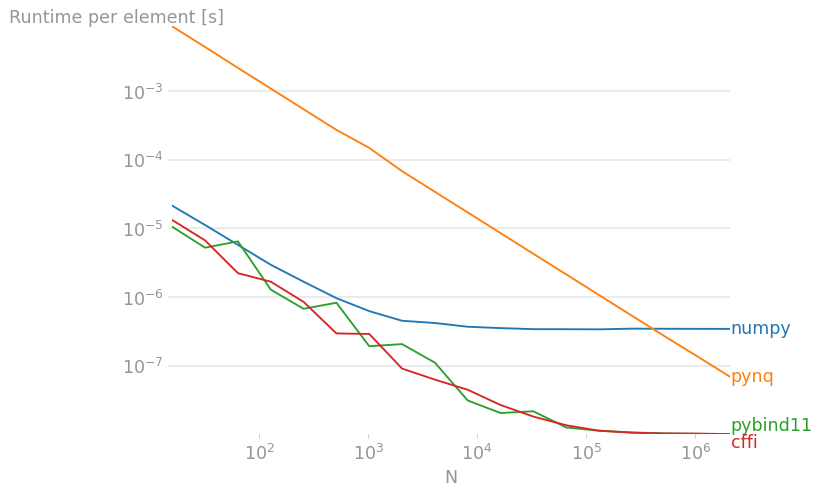

pynq_min = 262144
pybind11_min = 64
cffi_min = 0
Bitstream download time = 0.21886956600000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.1466975e-05      │ 0.02245696514375  │ 0.01368990703125   │ 0.01369260962500… │
│ 32      │ 1.121490312500000… │ 0.0112404147875   │ 0.006844926253125… │ 0.00684637090000… │
│ 64      │ 5.770635937500001… │ 0.00560435725468… │ 0.003426329442187… │ 0.00342207103281… │
│ 128     │ 2.96061796875e-06  │ 0.00280334304296… │ 0.001711203472656… │ 0.00171159548203… │
│ 256     │ 1.677232031250000… │ 0.00140084934570… │ 0.000855634881640… │ 0.00085581217968… │
│ 512     │ 9.657980468750001… │ 0.00070071208457… │ 0.000428308445507… │ 0.00042777560898… │
│ 1024    │ 6.25148046875e-07  │ 0.00036298021230… │ 0.000213932530761… │ 0.00021403032373… │
│ 2048    │ 4.523124511718750… │ 0.00017528177338… │ 0.000107076739257… │ 0.00010696090986… │
│ 4096    │ 4.196192871093750… │ 8.76614910400390… │ 5.354593393554687… │ 5.34977539306640… │
│ 8192    │ 3.701758178710937… │ 4.38528848999023… │ 2.674870340576172… │ 2.67621791259765… │
│ 16384   │ 3.536914489746094… │ 2.19266936401367… │ 1.337922880859375… │ 1.33855582641601… │
│ 32768   │ 3.413871490478516… │ 1.09609982055664… │ 6.701088671875000… │ 6.69754320678711… │
│ 65536   │ 3.408917373657226… │ 5.48394336853027… │ 3.352312417602539… │ 3.35328689117431… │
│ 131072  │ 3.392107376098633… │ 2.74266018676757… │ 1.681166172027588… │ 1.68115219497680… │
│ 262144  │ 3.471835132598877… │ 1.37145295219421… │ 8.456027168273926… │ 8.45507456207275… │
│ 524288  │ 3.459118623733521… │ 6.86660067558288… │ 4.277868890762329… │ 4.27775144004821… │
│ 1048576 │ 3.450623267173767… │ 3.45232620906829… │ 2.189011273384094… │ 2.19008304882049… │
│ 2097152 │ 3.445925787925720… │ 1.73099145555496… │ 1.144549289226532… │ 1.14449850368499… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

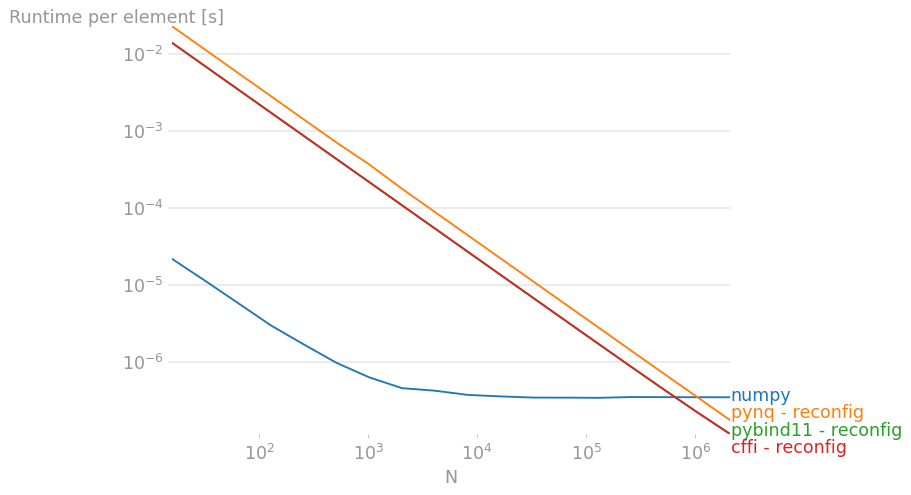

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [12]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    x2 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [multiply_call_i4_numpy, multiply_call_i4_pynq, multiply_call_i4_pybind11, multiply_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## true_divide_call_i4


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


kernel = numpy, n = 16, t = 0.0344358295
kernel = pynq, n = 16, t = 0.14151118740000002
kernel = pybind11, n = 16, t = 0.00016222800000000002
kernel = cffi, n = 16, t = 0.000220608
kernel = numpy, n = 32, t = 0.0004192293
kernel = pynq, n = 32, t = 0.1410951472
kernel = pybind11, n = 32, t = 0.00041495720000000005
kernel = cffi, n = 32, t = 0.00021877970000000002
kernel = numpy, n = 64, t = 0.00045208840000000004
kernel = pynq, n = 64, t = 0.1413817936
kernel = pybind11, n = 64, t = 0.0001601459
kernel = cffi, n = 64, t = 0.0002120105
kernel = numpy, n = 128, t = 0.0004928803
kernel = pynq, n = 128, t = 0.14135560960000002
kernel = pybind11, n = 128, t = 0.00016216950000000002
kernel = cffi, n = 128, t = 0.00021557070000000002
kernel = numpy, n = 256, t = 0.000519412
kernel = pynq, n = 256, t = 0.1415007847
kernel = pybind11, n = 256, t = 0.000422344
kernel = cffi, n = 256, t = 0.0002351378
kernel = numpy, n = 512, t = 0.0006480834000000001
kernel = pynq, n = 512, t = 0.1412559512
kern

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.00215223934375   │ 0.00884444921250… │ 1.013925000000000… │ 1.3788e-05        │
│ 32      │ 1.3100915625e-05   │ 0.00440922335     │ 1.296741250000000… │ 6.83686562500000… │
│ 64      │ 7.063881250000001… │ 0.002209090525    │ 2.5022796875e-06   │ 3.3126640625e-06  │
│ 128     │ 3.85062734375e-06  │ 0.00110434070000… │ 1.266949218750000… │ 1.68414609375000… │
│ 256     │ 2.028953125e-06    │ 0.00055273744023… │ 1.64978125e-06     │ 9.1850703125e-07  │
│ 512     │ 1.265787890625000… │ 0.00027589052968… │ 8.09230078125e-07  │ 2.98640625e-07    │
│ 1024    │ 8.176971679687501… │ 0.00013804444189… │ 4.178266601562500… │ 2.26820410156250… │
│ 2048    │ 6.340020996093751… │ 6.90887706542968… │ 2.130988281250000… │ 8.164736328125e-… │
│ 4096    │ 5.071546875000001… │ 3.44518653320312… │ 1.095457031250000… │ 6.33341552734375… │
│ 8192    │ 4.519916259765625… │ 1.72730963867187… │ 5.971007080078125… │ 3.53342041015625… │
│ 16384   │ 4.406473999023438… │ 8.63128533325195… │ 3.480136718750000… │ 2.61390686035156… │
│ 32768   │ 4.144433929443359… │ 4.31978032226562… │ 2.143573303222656… │ 1.79695648193359… │
│ 65536   │ 4.4290927734375e-… │ 2.17302686157226… │ 1.566425018310547… │ 1.37727798461914… │
│ 131072  │ 4.248258613586426… │ 1.08216364974975… │ 1.241809310913086… │ 1.12967155456542… │
│ 262144  │ 4.316718330383301… │ 5.41342544937133… │ 1.073035926818847… │ 1.06121894836425… │
│ 524288  │ 4.288841762542725… │ 2.71252944564819… │ 1.031559638977050… │ 1.03054088592529… │
│ 1048576 │ 4.181366376876831… │ 1.36972001647949… │ 1.016887569427490… │ 1.02715459823608… │
│ 2097152 │ 4.277734165191650… │ 6.92953710556030… │ 1.008656311035156… │ 1.00836020469665… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

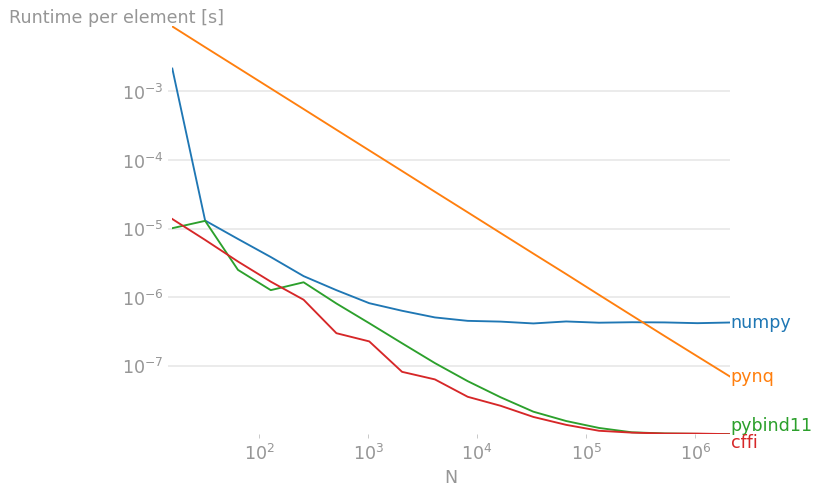

pynq_min = 262144
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.21520118700000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.00215223934375   │ 0.02229452340000… │ 0.0134602134375    │ 0.01346386218750… │
│ 32      │ 1.3100915625e-05   │ 0.01113426044375  │ 0.006738004506250… │ 0.00673187395937… │
│ 64      │ 7.063881250000001… │ 0.00557160907187… │ 0.0033650208265625 │ 0.00336583121093… │
│ 128     │ 3.85062734375e-06  │ 0.00278559997343… │ 0.001682526222656… │ 0.00168294341953… │
│ 256     │ 2.028953125e-06    │ 0.00139336707695… │ 0.000842279417968… │ 0.00084154814375… │
│ 512     │ 1.265787890625000… │ 0.00069620534804… │ 0.000421124048437… │ 0.00042061345898… │
│ 1024    │ 8.176971679687501… │ 0.00034820185107… │ 0.000210575235839… │ 0.00021038422958… │
│ 2048    │ 6.340020996093751… │ 0.00017416747524… │ 0.000105291803417… │ 0.00010516035195… │
│ 4096    │ 5.071546875000001… │ 8.69912176269531… │ 5.264889799804688… │ 5.26026864501953… │
│ 8192    │ 4.519916259765625… │ 4.35427725341796… │ 2.632938621826172… │ 2.63050103515625… │
│ 16384   │ 4.406473999023438… │ 2.17661234069824… │ 1.316963944091797… │ 1.31609771423339… │
│ 32768   │ 4.144433929443359… │ 1.08871993591308… │ 6.588854769897461… │ 6.58538860168457… │
│ 65536   │ 4.4290927734375e-… │ 5.45673638000488… │ 3.299373768615723… │ 3.29748229827880… │
│ 131072  │ 4.248258613586426… │ 2.72401840896606… │ 1.654272852325439… │ 1.65315147476196… │
│ 262144  │ 4.316718330383301… │ 1.36226992454528… │ 8.316577388763429… │ 8.31539569091797… │
│ 524288  │ 4.288841762542725… │ 6.81716634368896… │ 4.207792861938476… │ 4.20769098663330… │
│ 1048576 │ 4.181366376876831… │ 3.42203846549987… │ 2.154007205963135… │ 2.15503390884399… │
│ 2097152 │ 4.277734165191650… │ 1.71911293506622… │ 1.127024855613708… │ 1.12699524497985… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

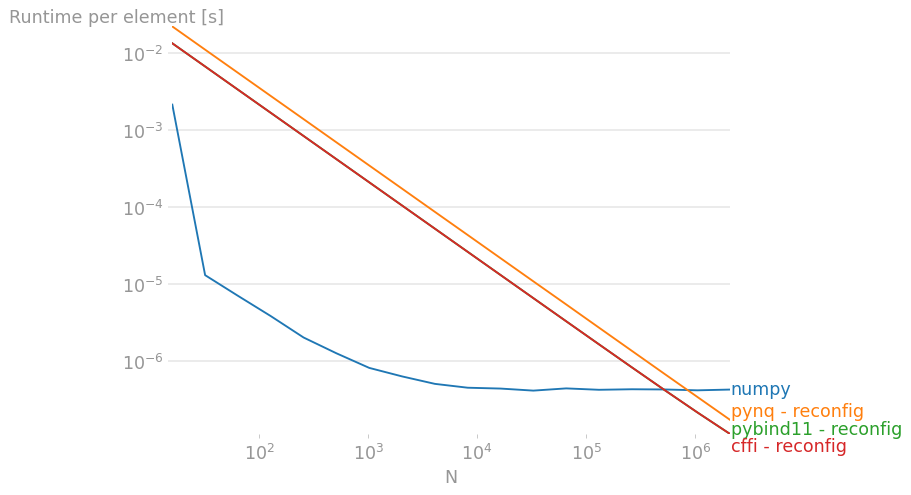

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [13]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    x2 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [true_divide_call_i4_numpy, true_divide_call_i4_pynq, true_divide_call_i4_pybind11, true_divide_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sqrt_call_i4


kernel = numpy, n = 16, t = 0.000492845
kernel = pynq, n = 16, t = 0.1177674986
kernel = pybind11, n = 16, t = 0.0001579218
kernel = cffi, n = 16, t = 0.0002126471
kernel = numpy, n = 32, t = 0.00035097730000000003
kernel = pynq, n = 32, t = 0.1171609306
kernel = pybind11, n = 32, t = 0.00015700520000000003
kernel = cffi, n = 32, t = 0.0002038144
kernel = numpy, n = 64, t = 0.0003640431
kernel = pynq, n = 64, t = 0.1181048506
kernel = pybind11, n = 64, t = 0.0003983126
kernel = cffi, n = 64, t = 0.0001345118
kernel = numpy, n = 128, t = 0.00037164340000000003
kernel = pynq, n = 128, t = 0.11743184350000001
kernel = pybind11, n = 128, t = 0.00039134550000000004
kernel = cffi, n = 128, t = 0.0001429736
kernel = numpy, n = 256, t = 0.0004303436
kernel = pynq, n = 256, t = 0.11715449390000002
kernel = pybind11, n = 256, t = 0.0001623289
kernel = cffi, n = 256, t = 0.00020832270000000004
kernel = numpy, n = 512, t = 0.0004876656
kernel = pynq, n = 512, t = 0.1174549528
kernel = pybind11, n 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.08028125e-05     │ 0.0073604686625   │ 9.8701125e-06      │ 1.329044375e-05   │
│ 32      │ 1.096804062500000… │ 0.00366127908125  │ 4.906412500000001… │ 6.3692e-06        │
│ 64      │ 5.6881734375e-06   │ 0.001845388290625 │ 6.223634375e-06    │ 2.101746875e-06   │
│ 128     │ 2.903464062500000… │ 0.00091743627734… │ 3.057386718750000… │ 1.11698125e-06    │
│ 256     │ 1.6810296875e-06   │ 0.00045763474179… │ 6.34097265625e-07  │ 8.13760546875000… │
│ 512     │ 9.52471875e-07     │ 0.00022940420468… │ 3.0755546875e-07   │ 4.27589453125e-07 │
│ 1024    │ 6.554094726562501… │ 0.00011469649589… │ 1.540768554687500… │ 1.44622167968750… │
│ 2048    │ 4.676255859375e-07 │ 5.73461529785156… │ 9.6322998046875e-… │ 1.45686572265625… │
│ 4096    │ 3.6724931640625e-… │ 2.86738123779296… │ 1.051131347656250… │ 6.27228271484375… │
│ 8192    │ 3.180943847656250… │ 1.43596119140625… │ 6.005461425781251… │ 3.52242065429687… │
│ 16384   │ 2.962517883300781… │ 7.17573916015625… │ 2.076777343750000… │ 2.6218115234375e… │
│ 32768   │ 2.870297180175782… │ 3.59602759094238… │ 2.194996948242187… │ 1.77265625000000… │
│ 65536   │ 3.063056594848633… │ 1.79789733123779… │ 1.250970916748047… │ 1.35078399658203… │
│ 131072  │ 3.024491943359375… │ 9.0133999710083e… │ 1.214106826782226… │ 1.11999298095703… │
│ 262144  │ 2.980078182220459… │ 4.49959851455688… │ 1.064521560668945… │ 1.05563110351562… │
│ 524288  │ 2.962618356704712… │ 2.25461901855468… │ 1.031922855377197… │ 1.02761806488037… │
│ 1048576 │ 2.954191431999207… │ 1.13726346302032… │ 1.016135225296020… │ 1.01603845596313… │
│ 2097152 │ 2.952713436603546… │ 5.75112736701965… │ 1.040020399093628… │ 1.00783820629119… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

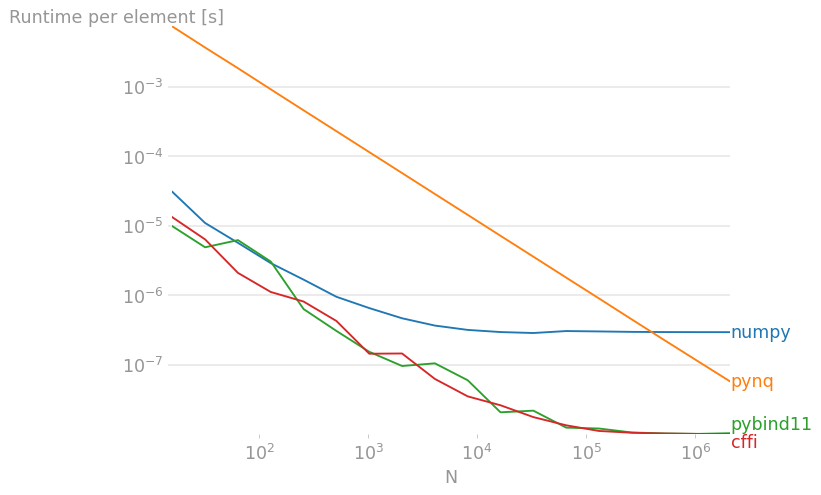

pynq_min = 262144
pybind11_min = 128
cffi_min = 0
Bitstream download time = 0.21928084


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.08028125e-05     │ 0.0210655211625   │ 0.0137149226125    │ 0.01371834294375  │
│ 32      │ 1.096804062500000… │ 0.01051380533125  │ 0.0068574326625    │ 0.00685889545     │
│ 64      │ 5.6881734375e-06   │ 0.005271651415625 │ 0.003432486759375  │ 0.003428364871875 │
│ 128     │ 2.903464062500000… │ 0.00263056783984… │ 0.001716188949218… │ 0.00171424854375… │
│ 256     │ 1.6810296875e-06   │ 0.00131420052304… │ 0.000857199878515… │ 0.00085737954179… │
│ 512     │ 9.52471875e-07     │ 0.00065768709531… │ 0.000428590446093… │ 0.00042871048007… │
│ 1024    │ 6.554094726562501… │ 0.00032883794121… │ 0.000214295522167… │ 0.00021428606748… │
│ 2048    │ 4.676255859375e-07 │ 0.00016441687563… │ 0.000107167045654… │ 0.00010721640922… │
│ 4096    │ 3.6724931640625e-… │ 8.22091737060546… │ 5.364047446289063… │ 5.35980841552734… │
│ 8192    │ 3.180943847656250… │ 4.11272925781250… │ 2.682773527832031… │ 2.68029048706054… │
│ 16384   │ 2.962517883300781… │ 2.05595794921875… │ 1.340460810546875… │ 1.34100584472656… │
│ 32768   │ 2.870297180175782… │ 1.02879477569580… │ 6.713870135498047… │ 6.70964672851562… │
│ 65536   │ 3.063056594848633… │ 5.14385741424560… │ 3.358469792175293… │ 3.35946792297363… │
│ 131072  │ 3.024491943359375… │ 2.57432003860473… │ 1.685121109771728… │ 1.68417997131347… │
│ 262144  │ 2.980078182220459… │ 1.28644987220764… │ 8.471352363586426… │ 8.47046331787109… │
│ 524288  │ 2.962618356704712… │ 6.43706912231445… │ 4.285642389297485… │ 4.28521191024780… │
│ 1048576 │ 2.954191431999207… │ 3.22848851490020… │ 2.192838574409485… │ 2.19282889747619… │
│ 2097152 │ 2.952713436603546… │ 1.62072526264190… │ 1.149614565849304… │ 1.14639634656906… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

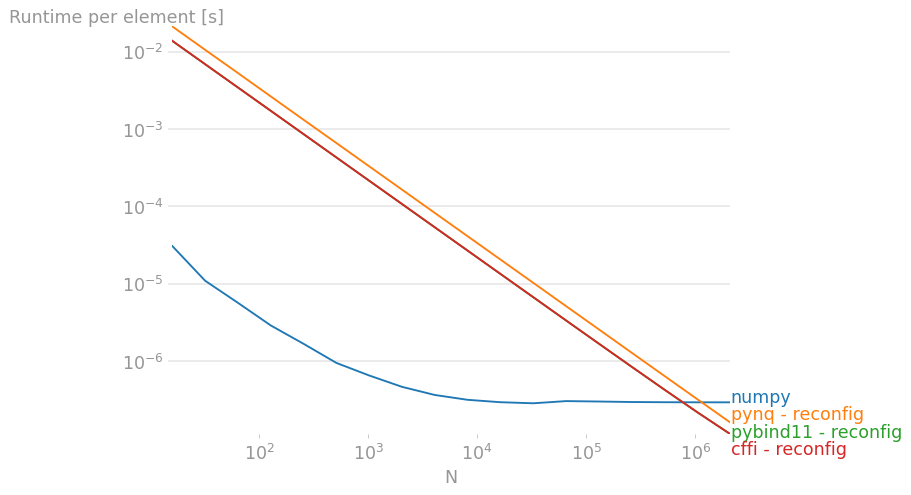

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [14]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sqrt_call_i4_numpy, sqrt_call_i4_pynq, sqrt_call_i4_pybind11, sqrt_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## exp_call_i4


kernel = numpy, n = 16, t = 0.00033731570000000005
kernel = pynq, n = 16, t = 0.11815196970000001
kernel = pybind11, n = 16, t = 0.0004025431
kernel = cffi, n = 16, t = 0.00013791170000000002
kernel = numpy, n = 32, t = 0.0003571856
kernel = pynq, n = 32, t = 0.1174121325
kernel = pybind11, n = 32, t = 0.00040144350000000003
kernel = cffi, n = 32, t = 0.00014902100000000002
kernel = numpy, n = 64, t = 0.00037069290000000003
kernel = pynq, n = 64, t = 0.11771521730000001
kernel = pybind11, n = 64, t = 0.0003970584000000001
kernel = cffi, n = 64, t = 0.00013749720000000003
kernel = numpy, n = 128, t = 0.00040082830000000004
kernel = pynq, n = 128, t = 0.11747585120000001
kernel = pybind11, n = 128, t = 0.00015804100000000001
kernel = cffi, n = 128, t = 0.0002038043
kernel = numpy, n = 256, t = 0.0004421153
kernel = pynq, n = 256, t = 0.1183214078
kernel = pybind11, n = 256, t = 0.0001515123
kernel = cffi, n = 256, t = 0.0002041276
kernel = numpy, n = 512, t = 0.0005149504
kernel = pynq, 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.108223125000000… │ 0.00738449810625… │ 2.515894375e-05    │ 8.61948125000000… │
│ 32      │ 1.116205e-05       │ 0.003669129140625 │ 1.254510937500000… │ 4.65690625000000… │
│ 64      │ 5.792076562500000… │ 0.00183930027031… │ 6.204037500000001… │ 2.14839375000000… │
│ 128     │ 3.131471093750000… │ 0.00091778008750… │ 1.234695312500000… │ 1.59222109375e-06 │
│ 256     │ 1.727012890625e-06 │ 0.00046219299921… │ 5.91844921875e-07  │ 7.973734375e-07   │
│ 512     │ 1.0057625e-06      │ 0.00023005666015… │ 7.87401171875e-07  │ 2.73952539062500… │
│ 1024    │ 6.6192431640625e-… │ 0.00011516410527… │ 1.638476562500000… │ 2.09926953125000… │
│ 2048    │ 5.018875e-07       │ 5.76513797363281… │ 1.98664111328125e… │ 8.14375488281250… │
│ 4096    │ 4.134597412109375… │ 2.87679403320312… │ 1.041689697265625… │ 4.29212158203125… │
│ 8192    │ 3.653988891601562… │ 1.43905367553710… │ 6.080560302734376… │ 3.37571044921875… │
│ 16384   │ 3.470550231933594… │ 7.20906658325195… │ 3.418810424804688… │ 2.18877014160156… │
│ 32768   │ 3.353154052734375… │ 3.60615162658691… │ 2.193692932128906… │ 1.75632720947265… │
│ 65536   │ 3.595833877563476… │ 1.80576359252929… │ 1.515691680908203… │ 1.33858642578125… │
│ 131072  │ 3.507023872375488… │ 9.02672784423828… │ 1.231892318725586… │ 1.11386177062988… │
│ 262144  │ 3.492050796508789… │ 4.51839241790771… │ 1.066542015075683… │ 1.05659648895263… │
│ 524288  │ 3.474527658462524… │ 2.26444212341308… │ 1.035300197601318… │ 1.02870565414428… │
│ 1048576 │ 3.470666806221008… │ 1.14187402057647… │ 1.015682716369629… │ 1.02872228622436… │
│ 2097152 │ 3.460800335884094… │ 5.77554726600647… │ 1.007827887535095… │ 1.00776145458221… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

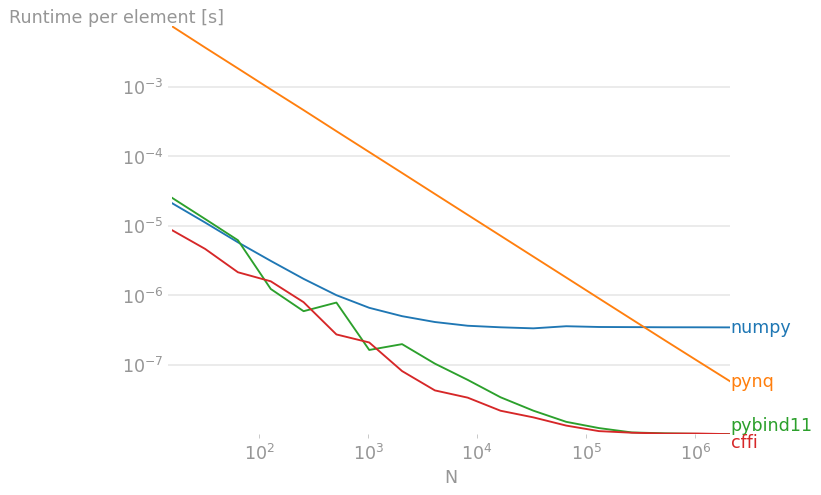

pynq_min = 262144
pybind11_min = 64
cffi_min = 0
Bitstream download time = 0.216201985


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.108223125000000… │ 0.02089712216875  │ 0.013537783006250… │ 0.01352124354375  │
│ 32      │ 1.116205e-05       │ 0.01042544117187… │ 0.006768857140625  │ 0.0067609689375   │
│ 64      │ 5.792076562500000… │ 0.00521745628593… │ 0.003384360053125… │ 0.00338030440937… │
│ 128     │ 3.131471093750000… │ 0.00260685809531… │ 0.001690312703125  │ 0.00169067022890… │
│ 256     │ 1.727012890625e-06 │ 0.001306732003125 │ 0.000845130848828… │ 0.00084533637734… │
│ 512     │ 1.0057625e-06      │ 0.00065232616210… │ 0.000423056903125  │ 0.00042254345449… │
│ 1024    │ 6.6192431640625e-… │ 0.00032629885625… │ 0.000211298598632… │ 0.00021134467792… │
│ 2048    │ 5.018875e-07       │ 0.00016321875522… │ 0.000105766039599… │ 0.00010564881303… │
│ 4096    │ 4.134597412109375… │ 8.15516280761718… │ 5.288785671386719… │ 5.28266089599609… │
│ 8192    │ 3.653988891601562… │ 4.07823806274414… │ 2.645264947509766… │ 2.64256009765625… │
│ 16384   │ 3.470550231933594… │ 2.04049885192871… │ 1.323011004028320… │ 1.32178096374511… │
│ 32768   │ 3.353154052734375… │ 1.02041125946044… │ 6.619897897338868… │ 6.61552424011230… │
│ 65536   │ 3.595833877563476… │ 5.10474407653808… │ 3.314137400817871… │ 3.31236634826660… │
│ 131072  │ 3.507023872375488… │ 2.55216302642822… │ 1.661809165191650… │ 1.66062885971069… │
│ 262144  │ 3.492050796508789… │ 1.27658436279296… │ 8.354105411529541… │ 8.35311085891723… │
│ 524288  │ 3.474527658462524… │ 6.38816772842407… │ 4.227255624771118… │ 4.22659617042541… │
│ 1048576 │ 3.470666806221008… │ 3.20373682308197… │ 2.163431074142456… │ 2.16473503112792… │
│ 2097152 │ 3.460800335884094… │ 1.60848612785339… │ 1.131714190006256… │ 1.13170754671096… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

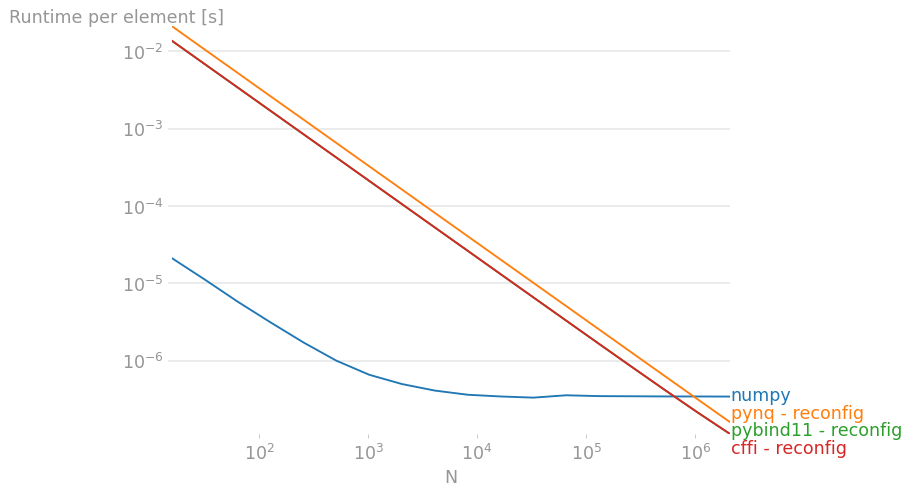

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [15]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [exp_call_i4_numpy, exp_call_i4_pynq, exp_call_i4_pybind11, exp_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## log_call_i4


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


kernel = numpy, n = 16, t = 0.0005001480000000001
kernel = pynq, n = 16, t = 0.11817158500000001
kernel = pybind11, n = 16, t = 0.0001573295
kernel = cffi, n = 16, t = 0.0002034634
kernel = numpy, n = 32, t = 0.00042078620000000005
kernel = pynq, n = 32, t = 0.1172349463
kernel = pybind11, n = 32, t = 0.0004042901
kernel = cffi, n = 32, t = 0.0001386055
kernel = numpy, n = 64, t = 0.0004323006
kernel = pynq, n = 64, t = 0.1173854928
kernel = pybind11, n = 64, t = 0.0001747394
kernel = cffi, n = 64, t = 0.00027485270000000004
kernel = numpy, n = 128, t = 0.0004627801
kernel = pynq, n = 128, t = 0.117524575
kernel = pybind11, n = 128, t = 0.0001502714
kernel = cffi, n = 128, t = 0.00020354470000000002
kernel = numpy, n = 256, t = 0.0005151109
kernel = pynq, n = 256, t = 0.11791496080000001
kernel = pybind11, n = 256, t = 0.000406421
kernel = cffi, n = 256, t = 0.0001380484
kernel = numpy, n = 512, t = 0.0005892003000000001
kernel = pynq, n = 512, t = 0.11784417770000001
kernel = pybind11

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.125925000000000… │ 0.00738572406250… │ 9.83309375e-06     │ 1.27164625e-05    │
│ 32      │ 1.314956875000000… │ 0.003663592071875 │ 1.2634065625e-05   │ 4.331421875e-06   │
│ 64      │ 6.754696875e-06    │ 0.001834148325    │ 2.730303125e-06    │ 4.29457343750000… │
│ 128     │ 3.61546953125e-06  │ 0.00091816074218… │ 1.1739953125e-06   │ 1.59019296875000… │
│ 256     │ 2.012151953125e-06 │ 0.00046060531562… │ 1.58758203125e-06  │ 5.392515625e-07   │
│ 512     │ 1.150781835937500… │ 0.00023016440957… │ 2.943642578125000… │ 2.748078125e-07   │
│ 1024    │ 7.915540039062501… │ 0.00011492632158… │ 4.099498046875000… │ 1.49296875e-07    │
│ 2048    │ 6.20110693359375e… │ 5.75765810546875… │ 1.996907714843750… │ 7.655146484375e-… │
│ 4096    │ 5.025405029296875… │ 2.87278045166015… │ 1.09260009765625e… │ 6.16511474609375… │
│ 8192    │ 4.491844604492187… │ 1.43534209594726… │ 5.976468505859376… │ 3.50537475585937… │
│ 16384   │ 4.308528198242187… │ 7.19878247680664… │ 2.020650634765625… │ 2.68045410156250… │
│ 32768   │ 4.328092498779297… │ 3.60623877258300… │ 2.165469055175781… │ 1.66547302246093… │
│ 65536   │ 4.362457534790039… │ 1.80464623260498… │ 1.526777038574218… │ 1.341650390625e-… │
│ 131072  │ 4.298230415344239… │ 8.99821557617187… │ 1.227578887939453… │ 1.12350906372070… │
│ 262144  │ 4.412603870391846… │ 4.53460927581787… │ 1.059128150939941… │ 1.07274017333984… │
│ 524288  │ 4.242772399902344… │ 2.25831105422973… │ 1.031801147460937… │ 1.02820962905883… │
│ 1048576 │ 4.23542274093628e… │ 1.14125220203399… │ 1.015827207565307… │ 1.02690740585327… │
│ 2097152 │ 4.382736483097076… │ 5.77446045875549… │ 1.008106670379638… │ 1.00870398044586… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

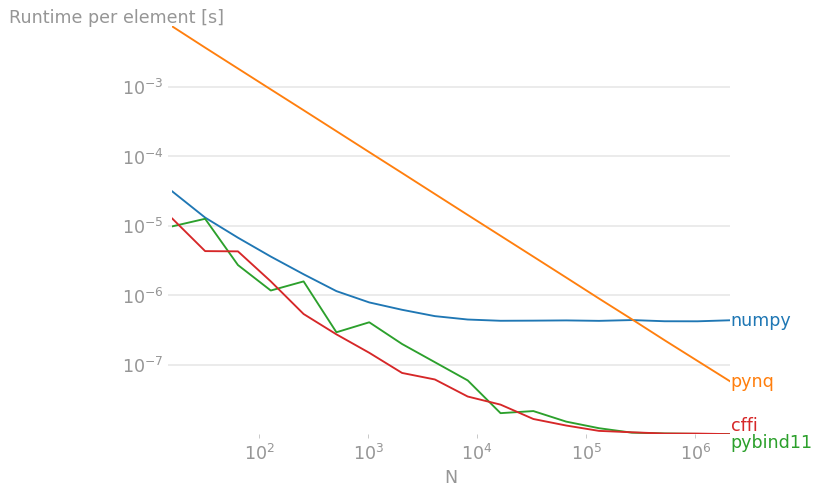

pynq_min = 262144
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.21609529800000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.125925000000000… │ 0.0208916801875   │ 0.013515789218750… │ 0.0135186725875   │
│ 32      │ 1.314956875000000… │ 0.010416570134375 │ 0.006765612128125… │ 0.00675730948437… │
│ 64      │ 6.754696875e-06    │ 0.00521063735625… │ 0.003379219334375… │ 0.00338078360468… │
│ 128     │ 3.61546953125e-06  │ 0.00260640525781… │ 0.001689418510937… │ 0.00168983470859… │
│ 256     │ 2.012151953125e-06 │ 0.00130472757343… │ 0.000845709839843… │ 0.00084466150937… │
│ 512     │ 1.150781835937500… │ 0.00065222553847… │ 0.000422355493164… │ 0.00042233593671… │
│ 1024    │ 7.915540039062501… │ 0.00032595688603… │ 0.000211440514257… │ 0.00021117986132… │
│ 2048    │ 6.20110693359375e… │ 0.00016309186328… │ 0.000105714972998… │ 0.00010559183369… │
│ 4096    │ 5.025405029296875… │ 8.14854456298828… │ 5.286690112304688… │ 5.28192922607421… │
│ 8192    │ 4.491844604492187… │ 4.07322415161132… │ 2.643858524169922… │ 2.64138743041992… │
│ 16384   │ 4.308528198242187… │ 2.03881927551269… │ 1.320961678466797… │ 1.32162148193359… │
│ 32768   │ 4.328092498779297… │ 1.02009439117431… │ 6.616359829711915… │ 6.61135986938476… │
│ 65536   │ 4.362457534790039… │ 5.10199880218505… │ 3.312620339965820… │ 3.31076907348632… │
│ 131072  │ 4.298230415344239… │ 2.54849784240722… │ 1.660952073669433… │ 1.65991137542724… │
│ 262144  │ 4.412603870391846… │ 1.27779906997680… │ 8.349294239044191… │ 8.35065544128418… │
│ 524288  │ 4.242772399902344… │ 6.38000176620483… │ 4.224870826721192… │ 4.22451167488098… │
│ 1048576 │ 4.23542274093628e… │ 3.20209755802154… │ 2.162428076744079… │ 2.16353609657287… │
│ 2097152 │ 4.382736483097076… │ 1.60786872386932… │ 1.131233345031738… │ 1.13129307603836… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

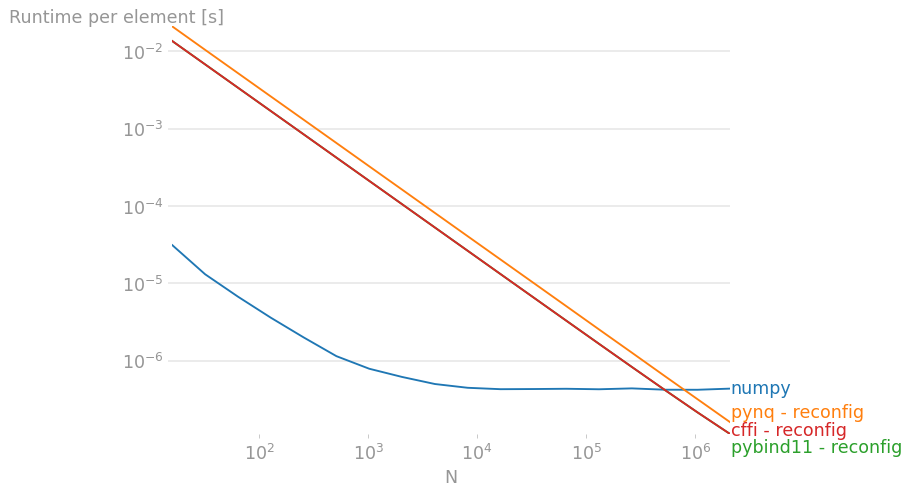

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [16]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="i4")
    out = allocate(shape=(M, N), dtype="i4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [log_call_i4_numpy, log_call_i4_pynq, log_call_i4_pybind11, log_call_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")